## Demonstation of human skeleton estimation from picture

In [1]:
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np


In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") ## weights 

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2 

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

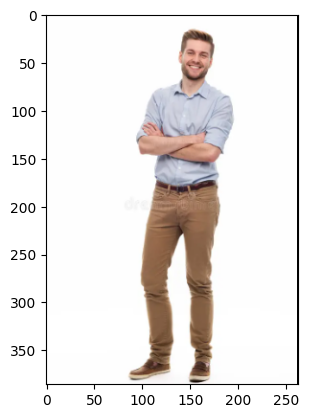

In [4]:
img = cv.imread("single_man.png")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [10]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []
    confidences = []  # Collect confidence scores

    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
        confidences.append(conf)  # Collect confidence scores


    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame, points, confidences

def visualize_heatmaps(heatmaps):
    fig = plt.figure(figsize=(15, 5))
    for i, heatmap in enumerate(heatmaps):
        body_part_index = i % len(BODY_PARTS)  # Ensure index wraps around BODY_PARTS length
        plt.subplot(3, 7, i + 1)
        plt.title(list(BODY_PARTS.keys())[body_part_index])  # Access BODY_PARTS based on heatmap index
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
    plt.tight_layout()
    plt.show() 

def visualize_confidence_scores(confidences):
    body_parts = list(BODY_PARTS.keys())
    
    plt.figure(figsize=(10, 6))
    plt.bar(body_parts, confidences, color='skyblue')
    plt.xlabel('Body Parts')
    plt.ylabel('Confidence Scores')
    plt.title('Confidence Scores for Detected Body Parts')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Confidence Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

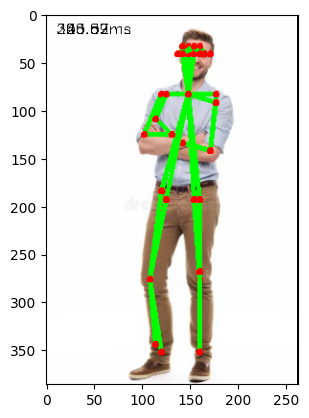

In [12]:
estimated_image, points, confidences = pose_estimation(img)
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))
 

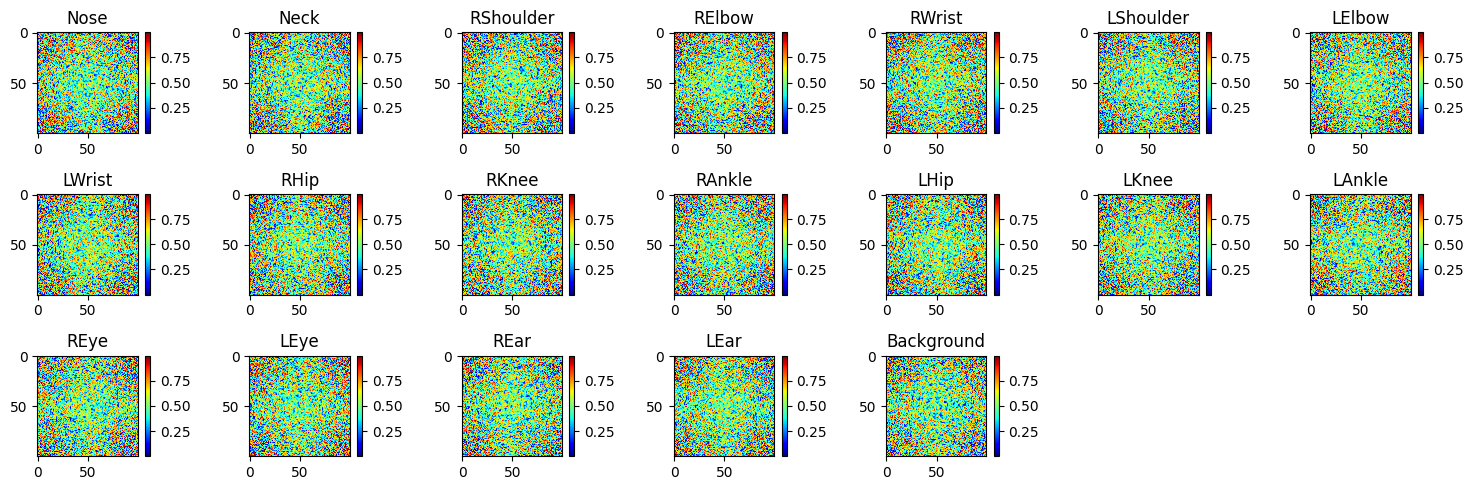

In [13]:
# Example usage:
# Assuming heatmaps is a list of heatmaps generated from pose estimation
heatmaps = [np.random.rand(100, 100) for _ in range(19)]  # Example random heatmaps
visualize_heatmaps(heatmaps)

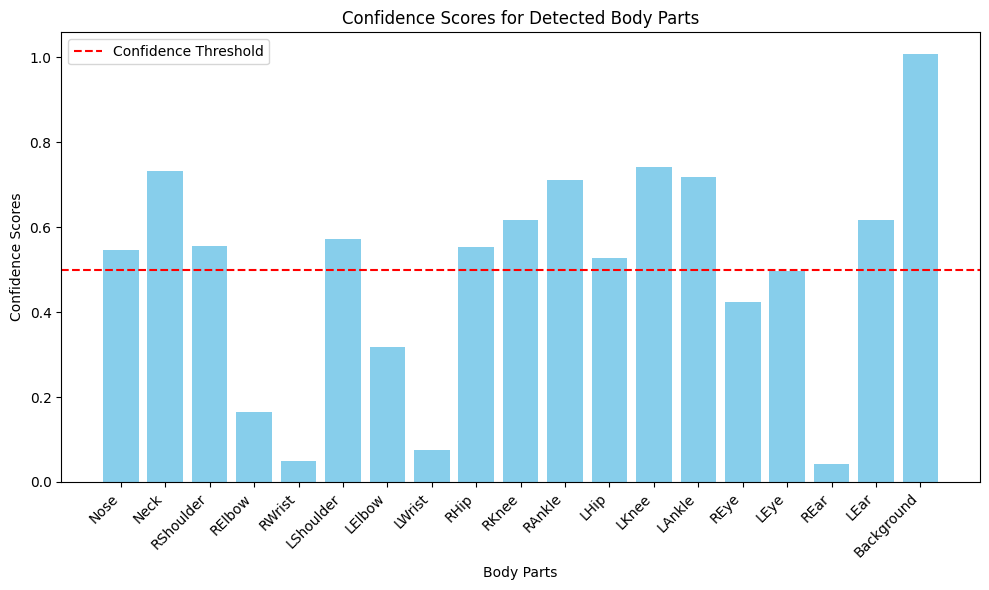

In [14]:
# Example usage:
visualize_confidence_scores(confidences)

## Perfrom demo on video

In [ ]:
import cv2 as cv

# Initialize video capture from file
cap = cv.VideoCapture("men_walking.mp4")

# Get video frame width and height
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
out_video = cv.VideoWriter('output_video.avi', cv.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

# Your pose estimation network initialization and other variables here
# Replace placeholders like inWidth, inHeight, BODY_PARTS, POSE_PAIRS, thr with actual values

# Processing loop
while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break  # Break the loop if no frame is read
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Perform pose estimation or other processing here
    # Replace with your actual pose estimation code
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] 

    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []
    
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Write the processed frame to the output video file
    out_video.write(frame)

    # Display the frame if needed
    #cv.imshow('Pose estimation trial', frame) 

    if cv.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit the loop
        break

# Release resources
cap.release()
out_video.release()
cv.destroyAllWindows()


## Demonstation of human skeleton estimation from webcam

In [ ]:
import cv2 as cv

# Initialize video capture from webcam (0 for default webcam)
cap = cv.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# Your pose estimation network initialization and other variables here
# Replace placeholders like inWidth, inHeight, BODY_PARTS, POSE_PAIRS, thr with actual values

# Processing loop
while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break  # Break the loop if no frame is read
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Perform pose estimation or other processing here
    # Replace with your actual pose estimation code
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] 

    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []
    
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Display the processed frame
    cv.imshow('Pose estimation trial', frame) 

    if cv.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit the loop
        break

# Release resources
cap.release()
cv.destroyAllWindows()


In [ ]:
print(confidences)

[0.8398242592811584, 0.7879541516304016, 0.752626895904541, 0.6909578442573547, 0.5133751034736633, 0.6624622941017151, 0.5722433924674988, 0.26272448897361755, 0.5269341468811035, 0.6400572061538696, 0.5497590899467468, 0.4623021185398102, 0.7112457752227783, 0.40797367691993713, 0.82077956199646, 0.781602144241333, 0.6350262761116028, 0.6156612038612366, 1.008272647857666]
